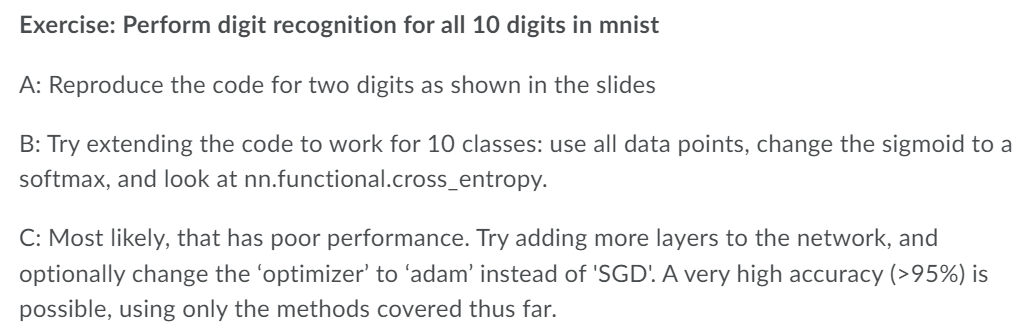

In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


In [6]:
device = torch.device('cpu')
if torch.cuda.is_available():
    cuda = torch.device('cuda:0')
    print(torch.version.cuda)
    print(torch.cuda.current_device())
    print(torch.cuda.device(0))
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))
    t = torch.cuda.get_device_properties(0).total_memory
    print(t/1e6)
    r = torch.cuda.memory_reserved(0)
    a = torch.cuda.memory_allocated(0)
    f = r-a
    print('reserved memory',r)
    print('allocated memory',a)
    print('free memory',f/1e6)
else:
    print('no cuda available')

11.8
0
1
NVIDIA GeForce RTX 4060 Laptop GPU
8585.216
reserved memory 0
allocated memory 0
free memory 0.0


In [5]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

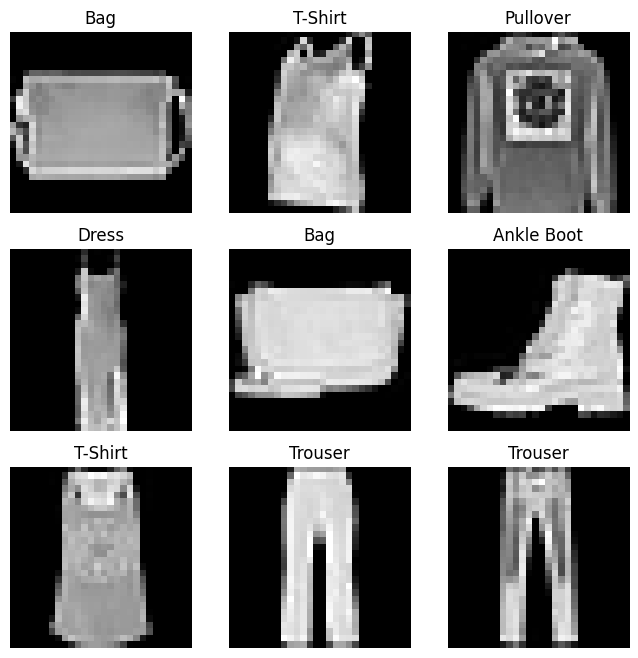

In [6]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [7]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [8]:

train_features, train_labels = next(iter(train_dataloader))

# Part A
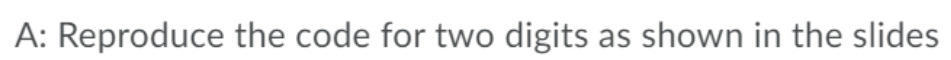